<a href="https://colab.research.google.com/github/BeckhamB/AIClassification/blob/main/t_SNE_Visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

# Visualising class features with t-SNE

This week I want to try and understand a bit more about my trained network.

I'm going to input images to a trained network and extract a feature vector for each image from the end of the network (by removing the final classification layer). These features vectors will then be fed into the t-distributed Stochastic Neighbor Embedding (t-SNE) [method](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) which will map the high-dimensional feature space to two dimensions so that images with similar features are close to each other in the 2D space.

I'm using my testing images and I want to compare the distribution of class features when extracted firstly with a ResNet18 network pre-trained on ImageNet and then secondly with the same network pre-trained on ImageNet and fine-tuned on my jellyfish dataset.

In [12]:
pip install split-folders[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
!unzip '/content/gdrive/MyDrive/arctic_dataset.zip' > /dev/null

replace arctic_dataset/bear/_113530377_bears_kt-miller.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [15]:
import splitfolders

splitfolders.ratio("arctic_dataset", output="split_arctic_dataset",
                   seed=1337, ratio=(.7, .15, .15), group_prefix=None, move=False)

Copying files: 642 files [00:00, 3660.00 files/s]


In [16]:
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU.')
else:
  print('CUDA is available. Training on GPU.')

CUDA is available. Training on GPU.


In [17]:
# imshow function for displaying images
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [18]:
# dataset directory
data_dir = 'split_arctic_dataset'

# define batch size
batch_size = 120

# define transforms
transform = transforms.Compose([transforms.Resize(224), # resize to 224x?
                                transforms.CenterCrop(224), # take a square (224x224) crop from the centre
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) # normalise for each colour channel

# choose the test dataset
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# prepare the data loader
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False)

In [19]:
# for t-SNE we will use a trained network to extract features for each image
# we will remove the final layer of the network so the output a 512 feature vector

# load model
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable

# load a pre-trained ResNet network with 18 layers
model = models.resnet50(pretrained=True)
# # remove the final layer so the output of the network is now a 512 feature vector
model = nn.Sequential(*list(model.children())[:-1])

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

print(model)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [20]:
# Load previously trained model

# create a new model with ResNet18 architecture
myModel = models.resnet50(pretrained=True)
# get the number of inputs for the final layer (fc) of the network
num_ftrs = myModel.fc.in_features
# replace the final layer so that the output is four classes
myModel.fc = nn.Linear(num_ftrs, 5)
# load previously trained model
myModel.load_state_dict(torch.load('/content/gdrive/MyDrive/resnet18_model_fine_tune_aug.pt'))
# remove the final layer so the output of the network is now a 512 feature vector
myModel = nn.Sequential(*list(myModel.children())[:-1])

# move tensors to GPU if CUDA is available
if train_on_gpu:
    myModel.cuda()

print(myModel)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [21]:
# Visualize Sample Test Results

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
imageNet_feats = model(images)
arctic_animals_feats = myModel(images)

# put on cpu, convert to numpy array and squeeze to batchsize x 512
imageNet_feats = np.squeeze(imageNet_feats.cpu().detach().numpy())
arctic_animals_feats = np.squeeze(arctic_animals_feats.cpu().detach().numpy())

labels = labels.numpy()

print(imageNet_feats.shape)
print(arctic_animals_feats.shape)
print(labels)

(100, 2048)
(100, 2048)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


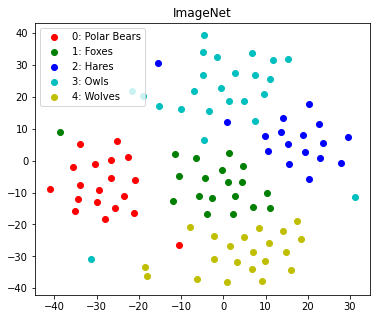

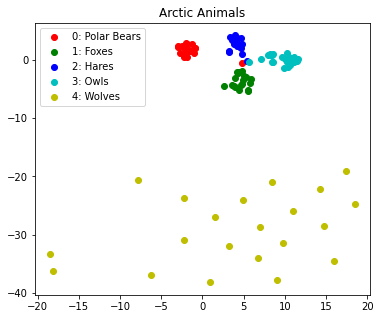

In [22]:
############################################################
# Fit and transform with a TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=1) 

############################################################
# Project the data in 2D
imageNet_X_2d = tsne.fit_transform(imageNet_feats)
jellyfish_X_2d = tsne.fit_transform(arctic_animals_feats)

############################################################
# Visualize the data
plt.figure(figsize=(6, 5))
for i in range(imageNet_X_2d.shape[0]):
  if labels[i] == 0:
    # 0 is Polar Bears
    class0 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='r')
  if labels[i] == 1:
    # 1 is Foxes
    class1 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='g')
  if labels[i] == 2:
    # 2 is Hares
    class2 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='b')
  if labels[i] == 3:
    # 3 is Owls
    class3 =  plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='c')
  if labels[i] == 4:
    # 4 is Wolves
    class4 =  plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='y')  
plt.title('ImageNet')
plt.legend((class0, class1, class2, class3, class4), ('0: Polar Bears', '1: Foxes', '2: Hares', '3: Owls', '4: Wolves')) 

# Visualize the data
plt.figure(figsize=(6, 5))

for i in range(jellyfish_X_2d.shape[0]):
  if labels[i] == 0:
    # 0 is Polar Bears
    class0 = plt.scatter(jellyfish_X_2d[i,0], jellyfish_X_2d[i, 1], c='r')
  if labels[i] == 1:
    # 1 is Foxes
    class1 = plt.scatter(jellyfish_X_2d[i,0], jellyfish_X_2d[i, 1], c='g')
  if labels[i] == 2:
    # 2 is Hares
    class2 = plt.scatter(jellyfish_X_2d[i,0], jellyfish_X_2d[i, 1], c='b')
  if labels[i] == 3:
    # 3 is Owls
    class3 = plt.scatter(jellyfish_X_2d[i,0], jellyfish_X_2d[i, 1], c='c')
  if labels[i] == 4:
    # 4 is Wolves
    class4 =  plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='y')  
plt.title('Arctic Animals')
plt.legend((class0, class1, class2, class3, class4), ('0: Polar Bears', '1: Foxes', '2: Hares', '3: Owls', '4: Wolves')) 
plt.show()

Next steps could be to plot images in the place of the points in the t-SNE plot and see if any patterns are noticeable in the images from each class.  

This idea is demonstrated in the following tutorial using OpenCV:
https://learnopencv.com/t-sne-for-feature-visualization/